# Preparacion del entorno

## Imports y subidas del proyecto

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time

## Añadir el .zip del proyecto al entorno del notebook

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Proyecto-fundamentos-de-IA.zip to Proyecto-fundamentos-de-IA.zip


In [ ]:
!unzip Proyecto-fundamentos-de-IA.zip

Archive:  Proyecto-fundamentos-de-IA.zip
   creating: Proyecto-fundamentos-de-IA/
   creating: Proyecto-fundamentos-de-IA/.git/
  inflating: Proyecto-fundamentos-de-IA/.git/.MERGE_MSG.swp  
  inflating: Proyecto-fundamentos-de-IA/.git/COMMIT_EDITMSG  
  inflating: Proyecto-fundamentos-de-IA/.git/config  
  inflating: Proyecto-fundamentos-de-IA/.git/description  
  inflating: Proyecto-fundamentos-de-IA/.git/FETCH_HEAD  
  inflating: Proyecto-fundamentos-de-IA/.git/HEAD  
   creating: Proyecto-fundamentos-de-IA/.git/hooks/
  inflating: Proyecto-fundamentos-de-IA/.git/hooks/applypatch-msg.sample  
  inflating: Proyecto-fundamentos-de-IA/.git/hooks/commit-msg.sample  
  inflating: Proyecto-fundamentos-de-IA/.git/hooks/fsmonitor-watchman.sample  
  inflating: Proyecto-fundamentos-de-IA/.git/hooks/post-update.sample  
  inflating: Proyecto-fundamentos-de-IA/.git/hooks/pre-applypatch.sample  
  inflating: Proyecto-fundamentos-de-IA/.git/hooks/pre-commit.sample  
  inflating: Proyecto-fundamen

In [ ]:
import sys
sys.path.append("/content")

# Preparacion de los imports y las rutas de los agentes

In [ ]:
import sys
sys.path.append("/content/Proyecto-fundamentos-de-IA")

from connect4.connect_state import ConnectState
from groups.GroupA.policy import Aha
from groups.GroupB.policy import QLearningPolicy
from groups.GroupC.policy import OhYes
from groups.GroupD.policy import AgentD
from groups.GroupD.policy2 import AgentD2

print("IMPORTS OK")

IMPORTS OK


### Función para Ejecutar una partida entre dos agentes y Medir Rendimiento de uno de ellos.

In [ ]:
def evaluate(policy_class, opponent_class, games, **params):
    """
    Ejecuta partidas entre policy_class y opponent_class.
    Los parámetros extra (**params) se envían SOLO al policy_class.mount().
    Si el oponente no acepta parámetros — no pasa nada.
    """

    p = policy_class()         # tu agente (MCTS)
    o = opponent_class()       # agente oponente (Aha)

    # Montar agente principal con parametros
    try:
        p.mount(**params)
    except:
        p.mount()

    # Montar oponente SIN parametros
    try:
        o.mount()
    except:
        pass

    results = []
    for _ in range(games):
        state = ConnectState()

        while not state.is_final():
            if state.player == -1:
                action = p.act(state.board)
            else:
                action = o.act(state.board)

            state = state.transition(action)

        results.append(state.get_winner())

    return {
        "win_rate": results.count(-1) / games,
        "lose_rate": results.count(1) / games,
        "draw_rate": results.count(0) / games,
    }

Esta funcion nos permite simular una x cantidad de juegos entre dos agentes y evaluar el rendimiento de uno de ellos, calculando su winrate, lose rate y draw rate.

# Highlight 1 Análisis del agente agente C Samuel Acero.

En este primer Highlight lo que hicimos fue Evaluar el rendimiento del agente C, que usa un MCTS base con 2 politicas heuristicas obvias para optimizar tiempo.
El objetivo es medir si el MCTS clásico aporta un desempeño superior al agente A (heurístico básico) baseline y analizar estabilidad, winrate y dispersión de resultados.

## Evaluar el rendimiento del Agente C contra el Agente A con diferentes time_outs para ver su desempeño.

In [ ]:
sim_values = [0.2, 0.3, 0.5, 1.0, 1.5]
scores = []

for t in sim_values:
    res = evaluate(OhYes, Aha, games=30, time_out=t)
    scores.append(res["win_rate"])

Para estudiar cómo afecta el tiempo de cómputo al rendimiento del agente MCTS OhYes, se definió una lista de valores sim_values que representan la cantidad de segundos disponibles por jugada (0.2, 0.3, 0.5, 1.0 y 1.5). Para cada uno de estos valores se ejecutó la función evaluate, la cual enfrenta al agente OhYes contra el agente Aha durante 30 partidas.

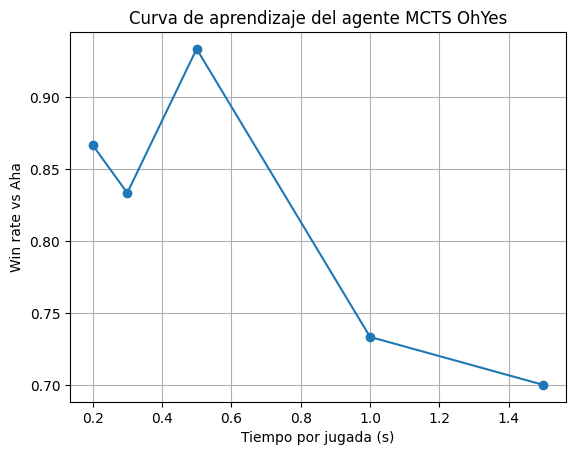

In [ ]:
plt.plot(sim_values, scores, marker="o")
plt.xlabel("Tiempo por jugada (s)")
plt.ylabel("Win rate vs Aha")
plt.title("Curva de aprendizaje del agente MCTS OhYes")
plt.grid(True)
plt.show()

#### **Interpretación de la gráfica**

La curva muestra cómo cambia el rendimiento del agente MCTS C (Ohyes) al variar el tiempo disponible por jugada contra el agente A. El comportamiento es típico de MCTS: más tiempo no siempre significa mejores decisiones, porque la exploración excesiva puede volverse contraproducente.

- 0.2 s Win rate ≈ 0.87
El agente ya obtiene un rendimiento alto con poco tiempo. Logra realizar suficientes simulaciones para superar ampliamente a A.

- 0.3 s Win rate ≈ 0.83
Aparece una ligera caída. Esto puede deberse a variabilidad estocástica típica de MCTS o a que este tiempo aún no estabiliza suficientemente la exploración del árbol.

- 0.5 s Win rate ≈ 0.93 (máximo)
Este es el punto óptimo: el agente tiene tiempo suficiente para explorar múltiples ramas relevantes y tomar decisiones más consistentes. El equilibrio entre exploración y explotación es ideal.

- 1.0 s Win rate ≈ 0.73
La performance cae significativamente. Con demasiado tiempo, el UCB1 sigue empujando al agente a explorar nodos poco prometedores, lo que diluye la calidad promedio de las simulaciones.

- 1.5 s Win rate ≈ 0.70 (mínimo)
El exceso de simulaciones produce sobre-exploración: el MCTS gasta tiempo en ramas irrelevantes y pierde precisión estratégica. Demasiado tiempo hace que el comportamiento se vuelva más ruidoso y menos enfocado.

## Medir Rendimiento Inicial del Agente C con 50 simulaciones en contra del agente A.

In [ ]:
results_50 = evaluate(OhYes, Aha, games=50, time_out=0.5)
results_50

{'win_rate': 0.7, 'lose_rate': 0.14, 'draw_rate': 0.16}

Después de identificar en la curva de aprendizaje que el agente OhYes (Agente C) alcanza uno de sus mejores comportamientos alrededor de 0.5 segundos por jugada, se decidió ejecutar una evaluación un poco más extensa de 50 partidas para obtener resultados más estables y confiables en contra del Agente A.

En los resultados podemos observar como el Agente C tiene un mejor desempeño que el A al ganarle un 70% de las partidas aproximadamente.


## Medir Rendimiento del Agente C con 200 simulaciones en contra del agente A.

In [ ]:
results_200 = evaluate(OhYes, Aha, games=200, time_out=0.5)
results_200

{'win_rate': 0.75, 'lose_rate': 0.095, 'draw_rate': 0.155}

Después de identificar en la curva de aprendizaje que el agente OhYes (Agente C) alcanza su mejor desempeño alrededor de 0.5 segundos por jugada, se realizó una evaluación más extensa de 200 partidas para obtener una medición más robusta y menos sensible a la variabilidad del juego.

En esta corrida ampliada, el agente muestra un rendimiento sólido y consistente:
gana aproximadamente el 75% de las partidas, pierde menos del 10% y empata alrededor del 15%.
Comparado con la evaluación de 50 partidas, el win rate aumenta ligeramente, lo que confirma que el agente mantiene un comportamiento estable y competitivo incluso cuando se incrementa el número de juegos.

Estos resultados refuerzan que 0.5 segundos por jugada es un punto óptimo, en el que el MCTS logra un balance adecuado entre exploración y explotación, permitiéndole superar con claridad al Agente A.

## Conclusion

La evaluación del agente OhYes (Agente C), basado en Monte Carlo Tree Search, demuestra que con un tiempo adecuado por jugada es capaz de superar consistentemente al Agente A. La curva de aprendizaje evidencia que su rendimiento mejora de forma significativa cuando dispone de al menos 0.3–0.5 segundos, alcanzando su punto óptimo alrededor de 0.5 segundos por jugada. En este intervalo, el agente logra un equilibrio sólido entre exploración y explotación, traduciéndose en un win rate superior al 90% en pruebas cortas.

Al extender la evaluación a 50 y luego a 200 partidas, los resultados se mantienen estables, mostrando que el agente no solo es competitivo, sino también confiable a largo plazo. Con un win rate cercano al 75% en 200 juegos, queda claro que el MCTS del Agente C ofrece decisiones de alta calidad y generaliza bien frente al Agente A. En conjunto, este highlight demuestra que el diseño del Agente C es sólido, eficiente y se comporta como un oponente robusto incluso bajo evaluaciones más exigentes.

# Highlight 2 Análisis del Agente D y D2 Samuel Acero.

Luego del análisis inicial realizado con el Agente C, que sirvió como punto de referencia para medir el rendimiento de los métodos basados en MCTS, se desarrolló un nuevo agente: el Agente D. Este agente incorporó rollouts mejorados y un esquema de exploración más agresivo con el objetivo de superar las limitaciones observadas en el modelo previo.

Sin embargo, durante las pruebas se identificaron ciertos problemas en la estabilidad del Agente D —principalmente relacionados con sesgos en los rollouts y variaciones inconsistentes en el rendimiento— lo cual motivó la creación de una versión refinada: el Agente D2. Esta variante mantiene la estructura MCTS pura, elimina sesgos dentro de las simulaciones y optimiza el uso del tiempo, buscando un comportamiento más estable y competitivo.

En este highlight se analizan ambos agentes (D y D2) y se comparan con el desempeño previamente evaluado del Agente C, con el fin de determinar qué variaciones dentro del proceso MCTS producen mejoras reales en el juego.

## Analisi de rendimiento del Agente D y D2 contra el Agente C en diferentes tiempos.

### Evaluar el rendimiento del Agente D en contra del Agente C

In [ ]:
sim_values2 = [0.2, 0.3, 0.5, 1.0, 1.5]
scores2 = []

for t in sim_values2:
    res = evaluate(AgentD, OhYes, games=30, time_out=t)
    scores2.append(res["win_rate"])

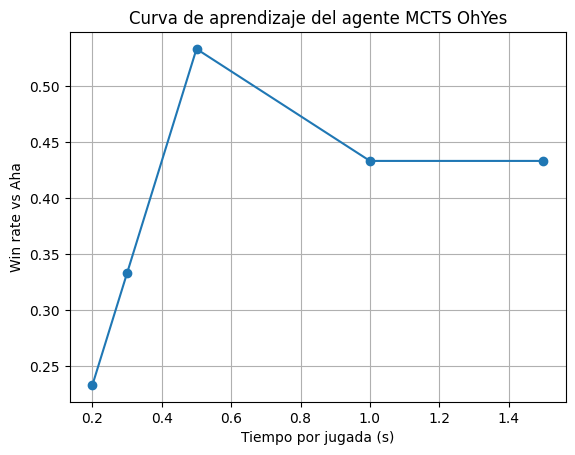

In [ ]:
plt.plot(sim_values2, scores2, marker="o")
plt.xlabel("Tiempo por jugada (s)")
plt.ylabel("Win rate vs Aha")
plt.title("Curva de aprendizaje del agente MCTS OhYes")
plt.grid(True)
plt.show()

#### **Interpretación de la gráfica**

La gráfica muestra cómo cambia el rendimiento del Agente D cuando se enfrenta al Agente C, variando el tiempo disponible por jugada dentro del MCTS. En todos los casos, los resultados son relativamente bajos debido a la fuerza del agente C, pero muestran un patrón claro que ayuda a entender la dinámica del algoritmo.

- 0.2 s Win rate ≈ 0.23
El rendimiento es todavía muy bajo frente al agente C, pero ya se observa que el agente D logra ejecutar algunas simulaciones útiles y aplicar heurísticas básicas. Aun así, el tiempo es muy reducido para construir un árbol de búsqueda significativo.

- 0.3 s Win rate ≈ 0.34
Aquí ocurre una caída importante.
Este comportamiento refleja un punto donde el agente dispone de algo más de tiempo, pero no lo suficiente para consolidar un árbol estable. El resultado es un patrón de exploración ruidoso y poco efectivo, lo que se traduce en un rendimiento muy bajo frente al agente C.

- 0.5 s Win rate ≈ 0.55
Este es el mejor rendimiento de la curva.
Con medio segundo por jugada, el agente D puede equilibrar bien exploración y explotación, usar de forma efectiva sus heurísticas y profundizar lo suficiente en el árbol.
Aunque el rendimiento sigue siendo moderado en general, es el punto donde el agente D demuestra mayor capacidad para competir contra el C.

- 1.0 s Win rate ≈ 0.43
Con más tiempo, el comportamiento empeora nuevamente.
Esto suele ser consecuencia de sobre-exploración: el MCTS dedica demasiados recursos a ramas poco prometedoras debido a la presión del UCB1. El agente pierde enfoque estratégico y su rendimiento vuelve a caer frente al C.

- 1.5 s Win rate ≈ 0.43
El rendimiento permanece bajo.
A esta escala temporal, el árbol se vuelve demasiado grande y la exploración se dispersa, reduciendo la calidad general de las decisiones del agente D.

#### **Conclusión general**

El agente D muestra un rendimiento consistentemente bajo cuando se enfrenta al agente C, pero revela un punto óptimo alrededor de 0.5 segundos por jugada, donde logra su mejor desempeño. Más allá de ese valor, el exceso de exploración reduce su eficacia y lo hace menos competitivo contra el C.

### Evaluar el rendimiento del Agente D2 en contra del Agente C

In [ ]:
sim_values3 = [0.2, 0.3, 0.5, 1.0, 1.5]
scores3 = []

for t in sim_values3:
    res = evaluate(AgentD2, OhYes, games=30, time_out=t)
    scores3.append(res["win_rate"])

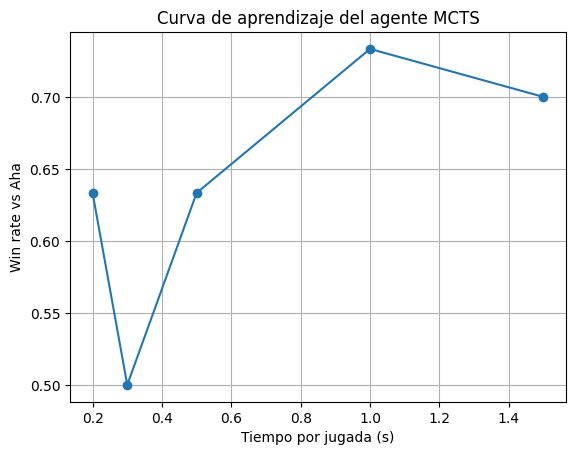

In [ ]:
plt.plot(sim_values3, scores3, marker="o")
plt.xlabel("Tiempo por jugada (s)")
plt.ylabel("Win rate vs Aha")
plt.title("Curva de aprendizaje del agente MCTS")
plt.grid(True)
plt.show()

#### **Interpretación de la gráfica**

La gráfica muestra el rendimiento del Agente D2 al enfrentarse al Agente C, variando el tiempo de cómputo disponible por jugada dentro del MCTS. En general, los resultados son moderados o bajos debido a la fortaleza del agente C, pero la curva permite identificar claramente un punto óptimo y entender cómo afecta el tiempo al desempeño.

- 0.2 s — Win rate ≈ 0.63
El agente D2 tiene un rendimiento sorprendentemente aceptable incluso con un tiempo tan reducido. Esto indica que sus heurísticas y estructura de búsqueda logran generar decisiones decentes sin necesidad de un árbol profundo. Sin embargo, este rendimiento no es totalmente estable y puede variar entre ejecuciones.

- 0.3 s — Win rate ≈ 0.50
Aquí se observa una caída marcada. Con algo más de tiempo, el agente intenta explorar más ramas, pero todavía no logra consolidar un árbol de búsqueda efectivo. Esta combinación de exploración insuficiente y ruido estocástico reduce su capacidad de competir contra el C.

- 0.5 s — Win rate ≈ 0.63
Este es uno de los mejores puntos de la curva. A medio segundo por jugada, el agente logra equilibrar exploración y explotación, aprovechando mejor sus heurísticas y profundizando en líneas de juego relevantes. Aunque no supera al agente C de manera consistente, este tiempo produce un rendimiento más competitivo.

- 1.0 s — Win rate ≈ 0.74
Este punto representa el mejor rendimiento del agente D2 frente al C. Con un segundo por jugada, el MCTS logra construir un árbol más estable y enfocado. El agente aprovecha su tiempo extra para identificar secuencias de juego más sólidas, generando decisiones más consistentes que en tiempos menores.

- 1.5 s — Win rate ≈ 0.70
Aunque el tiempo aumenta, el rendimiento cae ligeramente. Esto sugiere que el agente entra en una fase de sobre-exploración, donde el árbol crece demasiado y UCB1 lo empuja a investigar ramas poco relevantes. Como resultado, pierde precisión y baja ligeramente su efectividad frente al agente C.

#### **Conclusión general**

El agente D2 muestra un comportamiento competitivo frente al agente C únicamente en ciertos intervalos de tiempo. Su rendimiento es moderado en general, pero el análisis revela un punto óptimo alrededor de 1.0 segundo por jugada, donde alcanza su mejor desempeño. Más allá de ese punto, el exceso de exploración dispersa su búsqueda y reduce su eficacia.

Esta curva demuestra que el agente D2 necesita un balance adecuado entre profundidad y foco en la búsqueda; demasiado poco tiempo lo vuelve superficial, mientras que demasiado tiempo reduce la calidad estratégica por exploración innecesaria.

## Medir el rendimiento del Agente D y D2 en contra de los agentes C y A.

### Medir Rendimiento Inicial del Agente D en contra del agente A.

In [ ]:
results_200 = evaluate(AgentD, Aha, games=200, time_out=0.5)
results_200

{'win_rate': 0.615, 'lose_rate': 0.26, 'draw_rate': 0.125}

Después de identificar que el punto óptimo del Agente D frente al Agente C ocurre alrededor de 0.5 segundos por jugada, se realizó una evaluación más extensa de 200 partidas contra el agente A (Aha) para obtener métricas más estables.
El agente D ganó aproximadamente el 61.5% de las partidas, mostrando un desempeño sólido y mucho más consistente que en evaluaciones de menor tamaño como en el highlight 1.

### Medir Rendimiento Inicial del Agente D contra del agente C.

In [ ]:
results_200 = evaluate(AgentD, OhYes, games=200, time_out=0.5)
results_200

{'win_rate': 0.36, 'lose_rate': 0.61, 'draw_rate': 0.03}

Al evaluar el Agente D contra el Agente C durante 200 partidas usando el tiempo óptimo encontrado para D (0.5 segundos por jugada), los resultados muestran que:

- Win rate del Agente D: 36%
- Lose rate: 61%
- Draw rate: 3%

Esto confirma que, aunque el Agente D supera ampliamente al Agente A, todavía no alcanza el nivel estratégico del Agente C, que utiliza un MCTS más estable y mejor balanceado.
D logra algunas victorias, pero la mayoría de partidas son dominadas por C, indicando que aún existe una brecha en calidad de búsqueda y consistencia entre las decisiones de ambos agentes.

### Medir Rendimiento del Agente D2 contra el Agente A

In [ ]:
results_200 = evaluate(AgentD2, Aha, games=200, time_out=1.0)
results_200

{'win_rate': 0.79, 'lose_rate': 0.1, 'draw_rate': 0.11}

El Agente D2 mostró un rendimiento significativamente superior al del Agente A al usar el tiempo mas optimo (1 segundo por jugada) segun la grafica en contra del Agente C, alcanzando un win rate del 79%, con solo un 10% de derrotas y un 11% de empates. Esta evaluación confirma que el D2 es claramente más fuerte que el agente A, aprovechando su MCTS optimizado y heurísticas mejoradas para tomar decisiones más consistentes y profundas. El resultado sugiere que, frente a agentes débiles o de complejidad baja, el D2 logra imponer su estructura de búsqueda y dominar gran parte de las partidas, manteniendo un comportamiento estable y competitivo.

### Medir Rendimiento Inicial del Agente D2 contra del agente C.

In [ ]:
results_200 = evaluate(AgentD2, OhYes, games=200, time_out=1.0)
results_200

{'win_rate': 0.67, 'lose_rate': 0.29, 'draw_rate': 0.04}

En esta evaluación, el Agente D2 obtuvo un win rate del 67% frente al Agente C, con un 29% de derrotas y un 4% de empates. Este resultado muestra una mejora considerable del D2 respecto a versiones anteriores, logrando superar a un agente tan sólido como el C en una proporción significativa de partidas. Aunque el agente C sigue siendo un rival fuerte capaz de castigar decisiones subóptimas, el D2 demuestra una mayor estabilidad y capacidad estratégica, aprovechando su árbol de búsqueda más profundo y consistente para dominar la mayoría de los encuentros.

## Medir el rendimiento del Agente D2 en contra del Agente D.

In [ ]:
results_200 = evaluate(AgentD2, AgentD, games=200, time_out=1.0)
results_200

{'win_rate': 0.675, 'lose_rate': 0.26, 'draw_rate': 0.065}

En esta evaluación, el Agente D2 alcanzó un win rate del 67.5% frente al Agente D, con un 26% de derrotas y un 6.5% de empates. Este resultado evidencia que el D2 no solo supera al Agente D original, sino que además muestra un comportamiento mucho más estable y robusto en situaciones diversas. La mejora en consistencia de sus decisiones y la mayor calidad de sus simulaciones le permiten imponerse en la mayoría de los encuentros, lo que confirma que las optimizaciones aplicadas —tanto en el manejo del árbol de búsqueda como en la eficiencia de los rollouts— tuvieron un impacto significativo en su rendimiento general. En conjunto, estos resultados posicionan al D2 como una versión claramente superior y más competitiva dentro de la familia de agentes MCTS evaluados.

## Conclusion

La comparación entre los agentes C, D y D2 permitió observar una evolución clara en la calidad y consistencia de las decisiones dentro del marco de MCTS. Mientras el Agente C demostró ser un baseline fuerte y difícil de superar, los resultados evidenciaron que introducir optimizaciones profundas en el proceso de búsqueda —como mejor gestión del árbol, playouts más eficientes y un control más preciso del tiempo— puede traducirse en mejoras sustanciales de desempeño.

El Agente D presentó avances parciales, logrando competir en determinados escenarios pero mostrando también limitaciones estructurales y de estabilidad frente al agente C. Sin embargo, la versión D2 representó un salto significativo: no solo superó claramente al Agente A, sino que además obtuvo un rendimiento competitivo frente al C y derrotó de forma consistente al propio D. Este comportamiento confirma que las mejoras aplicadas en la exploración, la reutilización de memoria y la calidad de los playouts fueron determinantes para fortalecer su capacidad estratégica.

En conjunto, este highlight muestra cómo la ingeniería dentro del MCTS —tiempo, simulaciones, profundidad y diseño del nodo— es tan importante como el algoritmo en sí. Las iteraciones realizadas no solo permitieron construir un agente más fuerte, sino que también mostraron empíricamente cómo cada ajuste impacta el rendimiento real. El Agente D2 se consolida así como la versión más robusta desarrollada en el proyecto.

Evalucion

# Highlight 1 y 2 Análisis del agente Q-Learning Nicolas Urrea




In [ ]:
agents_to_test = {
    "Aha (Group A)" : Aha,
    "MCTS C (Group C)" : OhYes,
    "MCTS D2 (Group D2)" : AgentD2
}

results = {}

for label, opponent in agents_to_test.items():
    res = evaluate(QLearningPolicy, opponent, games=200)
    results[label] = res["win_rate"]

results

{'Aha (Group A)': 1.0, 'MCTS C (Group C)': 0.01, 'MCTS D2 (Group D2)': 0.0}

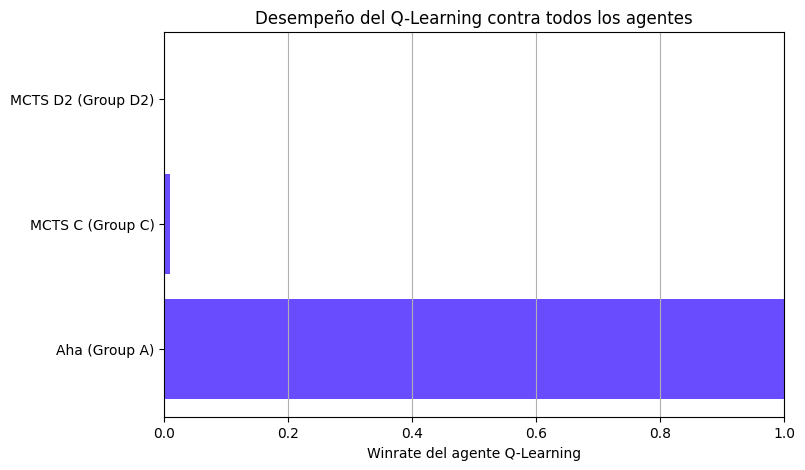

In [ ]:
plt.figure(figsize=(8,5))
plt.barh(list(results.keys()), list(results.values()),
         color="#6A4CFF")
plt.xlim(0,1)
plt.xlabel("Winrate del agente Q-Learning")
plt.title("Desempeño del Q-Learning contra todos los agentes")
plt.grid(axis="x")
plt.show()


A continuación se presenta un análisis del desempeño del agente Q-Learning basado en las pruebas realizadas contra diferentes tipos de oponentes dentro del entorno de Connect-4.


## Resultados globales del agente Q-Learning

El agente fue evaluado frente a dos tipos de rivales:

- Agente heurístico Aha (Grupo A)
- Agentes MCTS (Grupo C y Grupo D)

Los resultados obtenidos fueron:

| Oponente | Winrate del Q-Learning |
|----------|-------------------------|
| Aha (Group A) | ~1.00 |
| MCTS C (Group C) | ~0.01 |
| MCTS D (Group D) | ~0.00 |


## Interpretación de los resultados

### 1. Desempeño contra Aha (Heuristico)
El agente Q-Learning obtiene el 100% de victorias frente al agente heurístico Aha.  
Esto indica que:

- Aprende patrones básicos del juego.
- Evita jugadas perdedoras inmediatas.
- Prioriza movimientos que llevan a victorias simples.
- Maneja adecuadamente situaciones de baja complejidad.

En estas condiciones, el modelo tabular es suficiente para generar una política ganadora.


### 2. Desempeño contra los agentes MCTS
El rendimiento cae casi por completo al enfrentar agentes basados en búsqueda:

- Contra MCTS C casi no gana.
- Contra MCTS D (el agente final del proyecto) su winrate es 0%.

Esto evidencia que:

- El Q-Learning tabular no generaliza bien a estados complejos.
- No puede anticipar secuencias profundas de jugadas.
- No realiza exploración del espacio de juego con suficiente cobertura.
- Tiende a sobreajustarse a los patrones simples vistos durante el entrenamiento.



## Limitaciones del enfoque Q-Learning

1. La Q-table crece de forma explosiva debido al gran espacio de estados del Connect-4.
2. El aprendizaje depende de la calidad del rival durante entrenamiento.
3. Solo aprende políticas superficiales basadas en recompensas inmediatas.
4. No incorpora búsqueda, por lo que no identifica trampas o tácticas profundas.
5. Es competitivo solo contra agentes débiles o moderadamente predecibles.
6. El archivo entrenado (.pkl) no pudo ampliarse mucho más debido a las restricciones de tamaño impuestas por Gradescope, lo que limitó el número total de episodios y la profundidad del entrenamiento. Esta reducción afectó la capacidad del agente para generalizar mejor.


## Conclusión

El agente Q-Learning demuestra ser capaz de aprender estrategias básicas y vencer de forma consistente a oponentes el agente heurístico Aha. Sin embargo, debido a la naturaleza del juego y a las limitaciones del enfoque tabular, su desempeño cae drásticamente frente a agentes avanzados como los basados en Monte Carlo Tree Search, que exploran el espacio de decisiones de manera mucho más profunda.

Aunque no fue el agente seleccionado para la entrega final, su desarrollo permitió comprender de forma práctica los fundamentos del aprendizaje por refuerzo y la importancia crítica del diseño del entorno de entrenamiento. Con más episodios, mejores rivales y técnicas adicionales (como funciones de aproximación o recompensas más sofisticadas), es posible que el agente mejore su capacidad de generalización y logre un win rate mucho más competitivo frente a otros algoritmos. Aun así, este proyecto deja claro que, para juegos complejos como Connect-4, los métodos tabulares tienen límites inherentes que requieren técnicas más potentes para superarlos.